# Consumer Segmentation and Behavior Analysis

In [52]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
%cd /content/drive/MyDrive/Projects/Consumer Segmentation and Behavior Analysis/

/content/drive/MyDrive/Projects/Consumer Segmentation and Behavior Analysis


In [107]:
#!pip install kneed

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from kneed import KneeLocator
from collections import Counter

sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [55]:
# Import the data
df = pd.read_csv('data.csv', encoding="ISO-8859-1")
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Data Description:

* InvoiceNo: Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Code uniquely assigned to each distinct product.
* Description: Description of each product.
* Quantity: The number of units of a product in a transaction.
* InvoiceDate: The date and time of the transaction.
* UnitPrice: The unit price of the product.
* CustomerID: Identifier uniquely assigned to each customer.
* Country: The country of the customer.

In [56]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data Preprocessing

### Handle Missing Data and 0 values

In [57]:
# Checking missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [58]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percentage

,0
Description,0.268311
CustomerID,24.926694


CustomerID column contains nearly a quarter of missing data. This column is essential for clustering customer. Imputing such a large percentage of missing values may introduce noise. Hence, removing the missing values to maintain the integrity of the analysis.

Description column contains very small percentage of missing values. Hence, removing these values.

In [59]:
# Drop missing values
df.dropna(inplace=True)

# verify
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [60]:
# Check for 0 values
df['UnitPrice'].describe()

,UnitPrice
count,406829.000000
mean,3.460471
std,69.315162
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,38970.000000


The minimum unit price is 0; suggesting free item. Investigating further to understand their nature.

In [61]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,40.000000
mean,347.100000
std,1978.311813
min,1.000000
25%,1.000000
50%,4.500000
75%,24.000000
max,12540.000000


There are 33 transactions of product with 0 unit price. Removing these transactions as they are in small number also keeping them in the dataset may introduce noise.

In [62]:
df = df[df['UnitPrice'] > 0]
df.shape

(406789, 8)

### Handle Duplicates

In [63]:
# Check for duplicates
print(f"Duplicate rows in the dataset: {df.duplicated().sum()}")

Duplicate rows in the dataset: 5225


In [64]:
# Find duplicated rows
duplicate_rows = df[df.duplicated(keep = False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
duplicate_rows_sorted.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


We can see that there are identical rows. Removing these identical rows as these can introduce noise and inaccuracies in the analysis.

In [65]:
# Removing duplicate rows
df.drop_duplicates(inplace=True)

# verify
df.duplicated().sum()

0

### Check for Cancelled Transactions

In [66]:
df['TransactionStatus'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled_transactions = df[df['TransactionStatus'] == 'Cancelled']
cancelled_transactions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionStatus
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,Cancelled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,Cancelled
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,Cancelled
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,Cancelled
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,Cancelled


In [67]:
cancelled_transactions.describe().drop('CustomerID', axis = 1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


Negative values in Quantity columns confirms that these orders indeed were cancelled.

UnitPrice column has a considerable spread, indicating that a variety of products from low to high value were cancelled.

In [68]:
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100
print('Percentage of cancelled transactions:', round(cancelled_percentage, 2), '%')

Percentage of cancelled transactions: 2.21 %


### Check for StockCode Anomalities

In [69]:
unique_stock_codes = df['StockCode'].unique()
print('Number of unique stock codes:', len(unique_stock_codes))

Number of unique stock codes: 3684


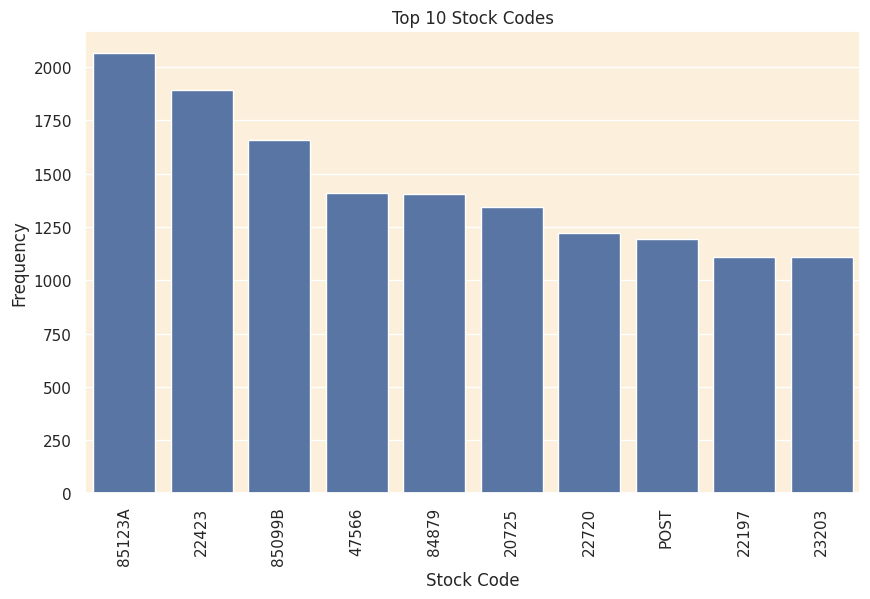

In [70]:
top10_stock_codes = df['StockCode'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top10_stock_codes.index, y=top10_stock_codes.values)
plt.xlabel('Stock Code')
plt.ylabel('Frequency')
plt.title('Top 10 Stock Codes')
plt.xticks(rotation=90)
plt.show()

The above plot shows the top 10 stock codes indicating the popular products or categories that are frequently purchased by customers.

We can also observe that while most of the stock codes are compose of 5 or 6 characters, there are some anomalies like the cose 'POST'. This might represent services or non-product transactions.

In [71]:
num_stock_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
print('Number of stock codes with numeric characters:')
print(num_stock_codes)

Number of stock codes with numeric characters:
5    3676
0       7
1       1
Name: count, dtype: int64


* 3676 out of 3684 contains exactly 5 numeric characters; seems to be the standard format for StockCode.
* 7 StockCodes contain no numeric characters and 1 contains only 1 numeric character. Need to investigate further to understand their purpose.

In [72]:
stock_code_anomalies = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0,1)]
print('Anomalies in StockCodes:')
print(stock_code_anomalies)

Anomalies in StockCodes:
['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']


These codes seem to represent non-product transactions which is not relevant for our analysis.

In [73]:
percentage_anomalies = df['StockCode'].isin(stock_code_anomalies).sum() / df.shape[0] * 100
print('Percentage of anomalies in StockCodes:', round(percentage_anomalies, 2), '%')

Percentage of anomalies in StockCodes: 0.48 %


A very small proportion of the records contains anomalies in StockCodes. Hence, removing these.

In [74]:
df = df[~df['StockCode'].isin(stock_code_anomalies)]
df.shape

(399656, 9)

### Check Decription Column

In [75]:
unique_desc = df['Description'].unique()
print('Number of unique descriptions:', len(unique_desc))

Number of unique descriptions: 3888


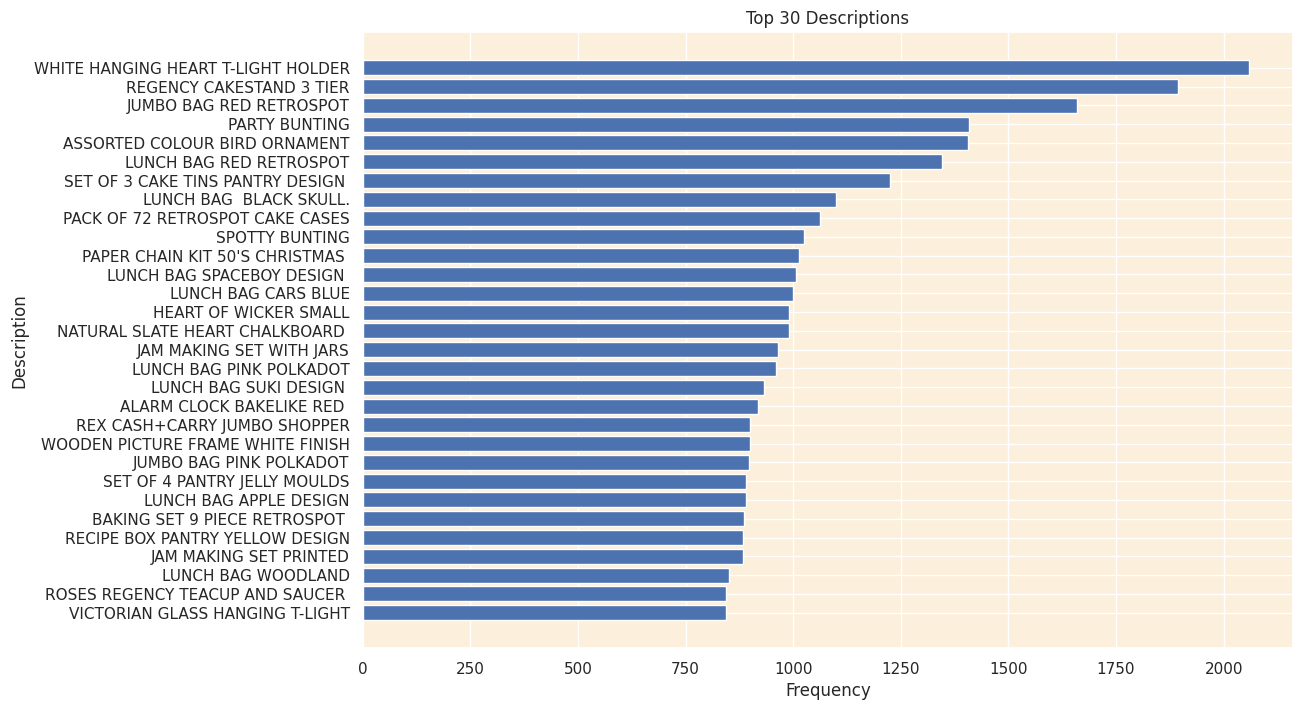

In [76]:
desc_count = df['Description'].value_counts()

top_30_desc = desc_count[:30]

plt.figure(figsize=(12, 8))
plt.barh(top_30_desc.index[::-1], top_30_desc.values[::-1])
plt.xlabel('Frequency')
plt.ylabel('Description')
plt.title('Top 30 Descriptions')
plt.show()

The most frequent descriptions are about household items like kitchenware, lunch bags and decorative items.

From the plot it is evident that all the description are in uppercase. Checking for anomalies in the description would be our next step.

In [77]:
lowercase_desc = [desc for desc in unique_desc if any(char.islower() for char in desc)]
print('Anomalies in descriptions:')
for desc in lowercase_desc:
    print(desc)

Anomalies in descriptions:
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


We can see that some entries are not product descriptions such as "High Resolution Image" and "Next Day Carriage". Removing these descriptions as they do not represent actual products.

Standardizing the remaining description as convert them to uppercase to maintain uniformity across the dataset.

In [78]:
service_related_desc = ['High Resolution Image', 'Next Day Carriage']

# Remove rows with service related description
df = df[~df['Description'].isin(service_related_desc)]

# Standardize the descriptions to uppercase
df['Description'] = df['Description'].str.upper()

In [79]:
df.shape

(399573, 9)

## Feature Engineering

In [80]:
df.reset_index(drop=True, inplace=True)
df.shape

(399573, 9)

### RFM Features

RFM is used for analyzing customer value and segmenting the customer base.
* Recency (R): Indicates how recent a customer has made a purchase. A lower value means the customer purchased recently indicating higher engagement with the brand.
* Frequency (F): Indicates how often a customer makes a purchase within a certain period. A higher frequency suggests higher loyalty or satisfaction.
* Monetary (M): Represents total amount of money a customer has spent over a certain period. Customer who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

In [81]:
## Analyzing Recency

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Get invoice data
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find most recent purchase date for each customer
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate Recency
customer_data['DaySinceLastPurchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

customer_data.drop(columns=['InvoiceDay'], inplace=True)
customer_data.head()

,CustomerID,DaySinceLastPurchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [82]:
## Analyzing Frequency

# Calculate total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Rename the column
total_transactions.rename(columns={'InvoiceNo': 'TotalTransactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'TotalProductsPurchased'}, inplace=True)

# Merge the two dataframes on CustomerID
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


In [83]:
## Analyzing Monetary

# Calculate total spend by each customer
df['TotalSpend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['TotalSpend'].sum().reset_index()

# Calculate the average transaction value for each customer
avg_transaction_value = total_spend.merge(total_transactions, on = 'CustomerID')
avg_transaction_value['AverageTransactionValue'] = avg_transaction_value['TotalSpend'] / avg_transaction_value['TotalTransactions']

# Merge these into customer_data
customer_data = pd.merge(customer_data, total_spend, on = 'CustomerID')
customer_data = pd.merge(customer_data, avg_transaction_value[['CustomerID', 'AverageTransactionValue']], on = 'CustomerID')

customer_data.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


### Product Diversity

In [84]:
# Calcualte unique products purchased by each customers
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'UniqueProductsPurchased'}, inplace=True)

# Merge these into customer_data
customer_data = pd.merge(customer_data, unique_products_purchased, on = 'CustomerID')

customer_data.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


### Behavioral Features

In [85]:
# Extract day of week adn hour from invoice date
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# Calculate average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
avg_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
avg_days_between_purchases.rename(columns={'InvoiceDay': 'AvgDaysBetweenPurchases'}, inplace=True)

# Identify favorite shopping day of the week
fav_shopping_day = df.groupby(['CustomerID', 'DayOfWeek']).size().reset_index(name = 'Count')
fav_shopping_day = fav_shopping_day.loc[fav_shopping_day.groupby('CustomerID')['Count'].idxmax()]
fav_shopping_day = fav_shopping_day[['CustomerID', 'DayOfWeek']]

# Find favorite shopping hour of the day
fav_shopping_hour = df.groupby(['CustomerID', 'HourOfDay']).size().reset_index(name = 'Count')
fav_shopping_hour = fav_shopping_hour.loc[fav_shopping_hour.groupby('CustomerID')['Count'].idxmax()]
fav_shopping_hour = fav_shopping_hour[['CustomerID', 'HourOfDay']]

# Merge these into customer_data
customer_data = pd.merge(customer_data, avg_days_between_purchases, on = 'CustomerID')
customer_data = pd.merge(customer_data, fav_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, fav_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


### Geographic Features

In [86]:
df['Country'].value_counts().head()

,count
Country,
United Kingdom,356008
Germany,9079
France,8152
EIRE,7368
Spain,2462


Given the substantial portion of transactions orignating from the United Kingdom, might consider creating a binary feature indicating whether transaction is from the UK or not.

In [87]:
# Calculate the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name = 'Number_of_Transactions')

# Find the country with the highest number of transactions for each customer
customer_main_country = customer_country.loc[customer_country.groupby('CustomerID')['Number_of_Transactions'].idxmax()]

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this features
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')
customer_data.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [88]:
customer_data['Is_UK'].value_counts()

,count
Is_UK,
1,3866
0,416


### Cancellation Insights

In [89]:
# Calculate total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate number of cancelled transactions for each customer
cancelled_frequency = df[df['TransactionStatus'] == 'Cancelled'].groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

cancelled_frequency.rename(columns={'InvoiceNo': 'CancellationFrequency'}, inplace=True)

# Merge
customer_data = pd.merge(customer_data, cancelled_frequency, on='CustomerID', how='left')

# Replace NaN with 0 (indicating customers who have not cancelled any transaction)
customer_data['CancellationFrequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['CancellationRate'] = customer_data['CancellationFrequency'] / total_transactions['InvoiceNo']
customer_data.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay,Is_UK,CancellationFrequency,CancellationRate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


### Seasonality and Trends

In [90]:
# Extract month and year from InvoiceDate
df['Year'] = df["InvoiceDate"].dt.year
df['Month'] = df["InvoiceDate"].dt.month

# Calculate total sales for each month per customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['TotalSpend'].sum().reset_index()

# Calculate seasonal buying patterns (Using monthly frequency as a proxy for seasonal buying patterns)
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['TotalSpend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'MonthlySpending_Mean', 'std': 'MonthlySpending_Std'}, inplace=True)

# Replace NaN with 0 (implying no variability for customer with single transaction)
seasonal_buying_patterns['MonthlySpending_Std'].fillna(0, inplace=True)

In [91]:
# Calculate trends in spending
def calc_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
      return 0

spending_trends = monthly_spending.groupby('CustomerID')['TotalSpend'].apply(calc_trend).reset_index()
spending_trends.rename(columns={'TotalSpend': 'SpendingTrend'}, inplace=True)

# Merge
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')
customer_data.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay,Is_UK,CancellationFrequency,CancellationRate,MonthlySpending_Mean,MonthlySpending_Std,SpendingTrend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [92]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               4282 non-null   float64
 1   DaySinceLastPurchase     4282 non-null   int64  
 2   TotalTransactions        4282 non-null   int64  
 3   TotalProductsPurchased   4282 non-null   int64  
 4   TotalSpend               4282 non-null   float64
 5   AverageTransactionValue  4282 non-null   float64
 6   UniqueProductsPurchased  4282 non-null   int64  
 7   AvgDaysBetweenPurchases  4282 non-null   float64
 8   DayOfWeek                4282 non-null   int32  
 9   HourOfDay                4282 non-null   int32  
 10  Is_UK                    4282 non-null   int64  
 11  CancellationFrequency    4282 non-null   float64
 12  CancellationRate         4282 non-null   float64
 13  MonthlySpending_Mean     4282 non-null   float64
 14  MonthlySpending_Std     

In [93]:
# Correcting the datatype of customer_data
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)
customer_data = customer_data.convert_dtypes()
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               4282 non-null   string 
 1   DaySinceLastPurchase     4282 non-null   Int64  
 2   TotalTransactions        4282 non-null   Int64  
 3   TotalProductsPurchased   4282 non-null   Int64  
 4   TotalSpend               4282 non-null   Float64
 5   AverageTransactionValue  4282 non-null   Float64
 6   UniqueProductsPurchased  4282 non-null   Int64  
 7   AvgDaysBetweenPurchases  4282 non-null   Float64
 8   DayOfWeek                4282 non-null   Int32  
 9   HourOfDay                4282 non-null   Int32  
 10  Is_UK                    4282 non-null   Int64  
 11  CancellationFrequency    4282 non-null   Int64  
 12  CancellationRate         4282 non-null   Float64
 13  MonthlySpending_Mean     4282 non-null   Float64
 14  MonthlySpending_Std     

In [94]:
customer_data.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay,Is_UK,CancellationFrequency,CancellationRate,MonthlySpending_Mean,MonthlySpending_Std,SpendingTrend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0


## Check for Outliers

Given the multi-dimensional nature of the data, using Isolation Forest algorithm to detect outliers.

In [95]:
model = IsolationForest(contamination=0.05, random_state = 42)

customer_data['OutlierScores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Create a new column to identify outliers (1: inliers, -1: outliers)
customer_data['IsOutlier'] = [1 if x == -1 else 0 for x in customer_data['OutlierScores']]
customer_data.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay,Is_UK,CancellationFrequency,CancellationRate,MonthlySpending_Mean,MonthlySpending_Std,SpendingTrend,OutlierScores,IsOutlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


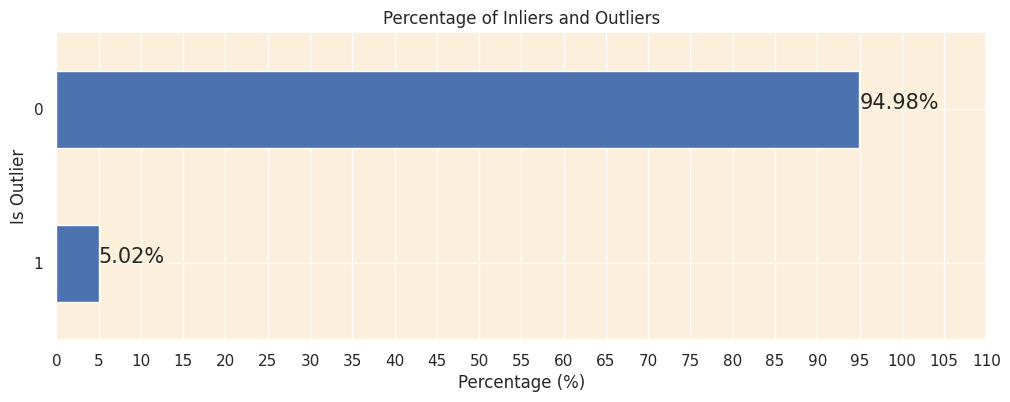

In [96]:
outlier_percentage = customer_data['IsOutlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh')
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)
    plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

5% of customers have been identified as outliers hence it can removed.

In [97]:
# Separate the outlier for analysis
outliers_data = customer_data[customer_data['IsOutlier'] == 1]

# Remove outliers
customer_data_cleaned = customer_data[customer_data['IsOutlier'] == 0]

customer_data_cleaned = customer_data_cleaned.drop(columns=['OutlierScores', 'IsOutlier'])
customer_data_cleaned.reset_index(drop=True, inplace=True)

print(customer_data_cleaned.shape)
customer_data_cleaned.head()

(4067, 16)


,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay,Is_UK,CancellationFrequency,CancellationRate,MonthlySpending_Mean,MonthlySpending_Std,SpendingTrend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0


## Correlation Analysis

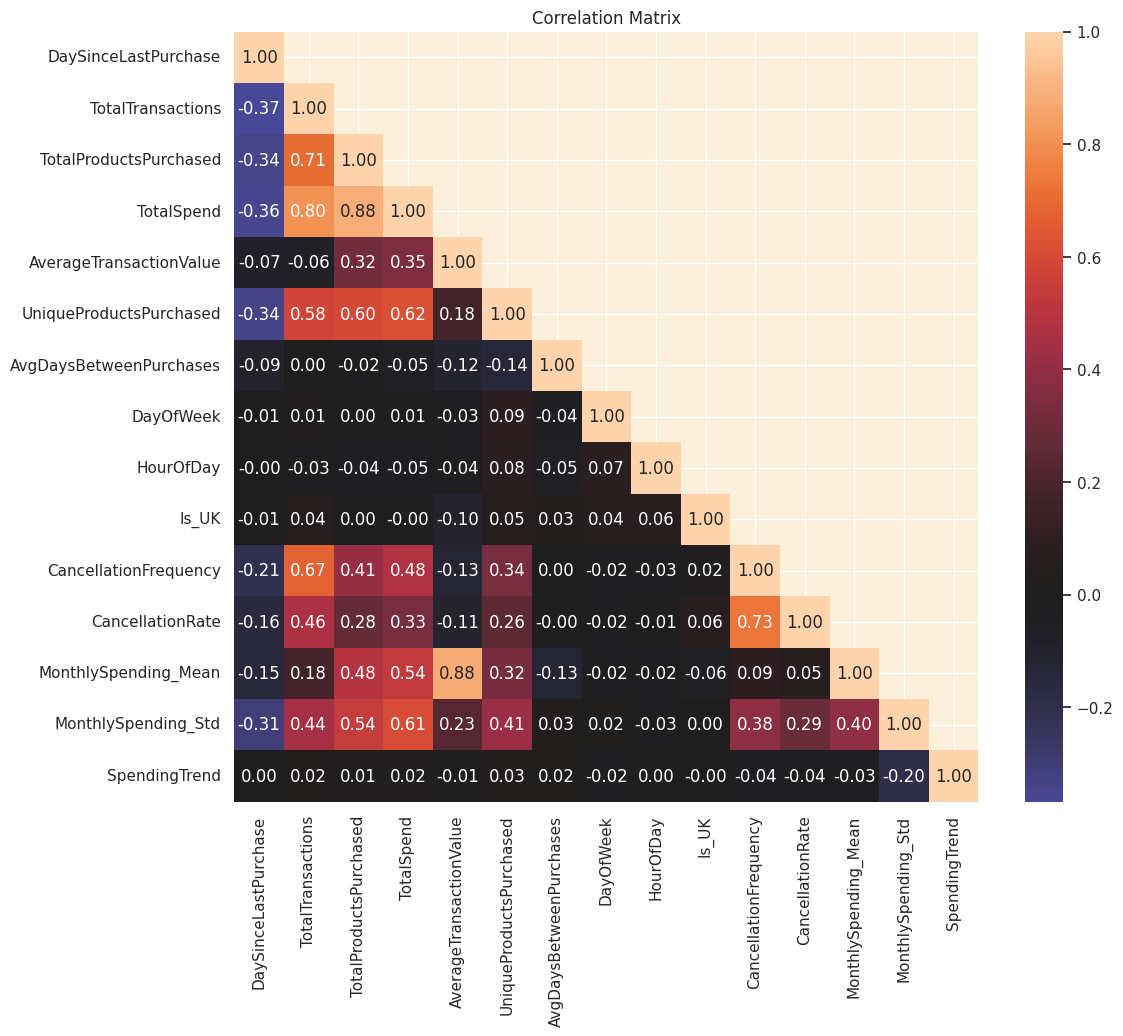

In [98]:
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Create a mask to only show the lower triangle of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

High correlation pairs:
* Monthly_Spending_Mean and Average_Transaction_Value
* Total_Spend and Total_Products_Purchased
* Total_Transactions and Total_Spend
* Cancellation_Rate and Cancellation_Frequency
* Total_Transactions and Total_Products_Purchased

Treating these using PCA; will help achieve more stable clusters.

## Feature Scaling

In [99]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'DayOfWeek']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

customer_data_scaled = customer_data_cleaned.copy()
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])
customer_data_scaled.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay,Is_UK,CancellationFrequency,CancellationRate,MonthlySpending_Mean,MonthlySpending_Std,SpendingTrend
0,12346.0,2.350329,-0.470250,-0.786144,-0.829824,-1.326493,-0.889092,-0.336044,1,-1.093494,1,0.360314,0.371881,-1.346779,-0.724928,0.092604
1,12347.0,-0.901915,0.649353,2.108572,2.413080,1.564977,0.768544,-0.132491,1,0.642861,0,-0.525122,-0.422529,1.018951,1.304784,0.118692
2,12348.0,-0.166888,-0.022409,1.960185,0.251575,0.360871,-0.564066,0.762651,3,2.813304,0,-0.525122,-0.422529,0.033781,0.488336,-0.494076
3,12349.0,-0.740813,-0.694170,-0.044211,0.266857,5.518340,0.264753,-0.336044,0,-1.527582,0,-0.525122,-0.422529,4.253498,-0.724928,0.092604
4,12350.0,2.199296,-0.694170,-0.555320,-0.608314,0.056045,-0.645322,-0.336044,2,1.511038,0,-0.525122,-0.422529,-0.215620,-0.724928,0.092604


## Dimensionality Reduction: PCA

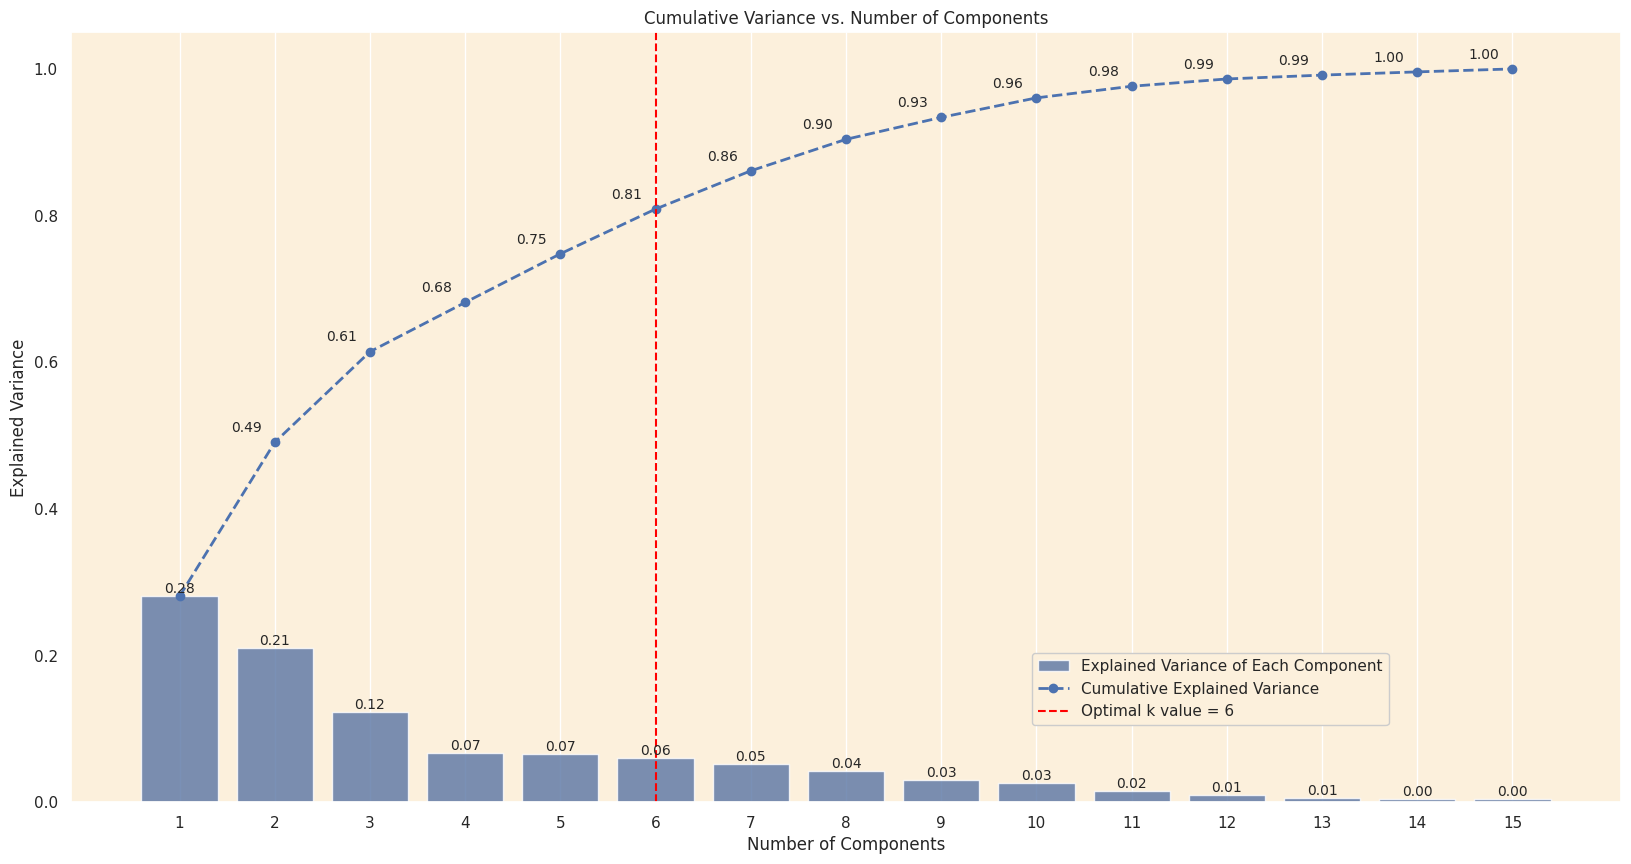

In [100]:
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value
optimal_k = 6

plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', linewidth=2)

optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Cumulative Variance vs. Number of Components')
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0)
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

The plot indicates how much of the total variance in the dataset is captured by each principal component and the cumulative variance explained by the first n components.

we can observe that:

* The first component explains approximately 28% of the variance.

* The first two components together explain about 49% of the variance.

* The first three components explain approximately 61% of the variance, and so on.

In [101]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

customer_data_pca = pca.fit_transform(customer_data_scaled)

# Create a DataFrame with the principal components
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])
customer_data_pca.index = customer_data_scaled.index
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.309199,-1.520713,-1.634860,-0.523483,-0.944116,-1.704848
12347.0,3.192271,-1.670956,1.998334,0.676769,0.430375,0.958035
12348.0,0.674337,0.513417,0.653051,0.361625,0.029832,2.598876
12349.0,1.471136,-2.916501,6.023090,-0.577609,0.273499,-1.654139
12350.0,-2.026054,-0.412933,0.492799,0.315474,-1.538141,0.374386


In [102]:
# Function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
DaySinceLastPurchase,-0.218512,0.005272,0.053009,-0.117092,-0.375856,-0.340329
TotalTransactions,0.384107,-0.012194,-0.248869,0.123661,0.019337,-0.033099
TotalProductsPurchased,0.403259,-0.021947,0.072460,0.107493,0.087681,-0.002695
TotalSpend,0.429774,-0.022245,0.066027,0.082084,0.050336,-0.032172
AverageTransactionValue,0.156888,-0.034979,0.600433,-0.073354,-0.019496,-0.093912
UniqueProductsPurchased,0.335427,0.040347,0.011954,0.240250,-0.093103,0.142161
AvgDaysBetweenPurchases,-0.026824,-0.027969,-0.140954,-0.113066,0.764534,0.163934
DayOfWeek,0.043312,0.994369,0.010079,-0.030633,0.038769,-0.065711
HourOfDay,-0.013020,0.057568,-0.008346,0.277634,-0.368641,0.770971
Is_UK,0.001535,0.006770,-0.018357,0.007284,-0.001768,0.016947


## K-Means Clustering

#### Determine Optimal Number of Clusters (K)

In [104]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.309199,-1.520713,-1.634860,-0.523483,-0.944116,-1.704848
12347.0,3.192271,-1.670956,1.998334,0.676769,0.430375,0.958035
12348.0,0.674337,0.513417,0.653051,0.361625,0.029832,2.598876
12349.0,1.471136,-2.916501,6.023090,-0.577609,0.273499,-1.654139
12350.0,-2.026054,-0.412933,0.492799,0.315474,-1.538141,0.374386


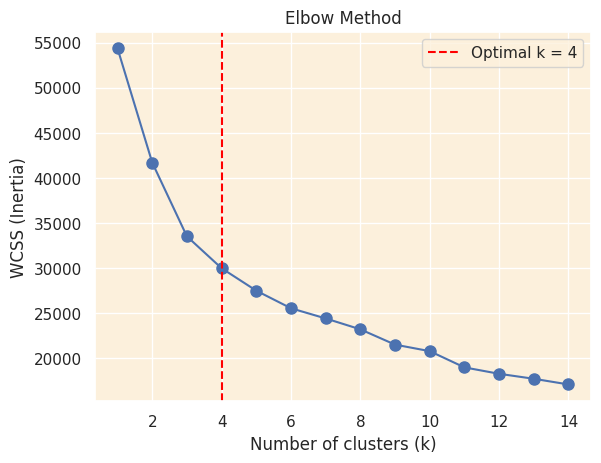

In [113]:
# Elbow Method
wcss = []
k_values = range(1, 15)

for k in k_values:
    kmeans = KMeans(init='k-means++', n_clusters=k, random_state=42)
    kmeans.fit(customer_data_pca)
    wcss.append(kmeans.inertia_)

# Automatically find the optimal k using KneeLocator
kn = KneeLocator(k_values, wcss, curve='convex', direction='decreasing')
optimal_k = kn.knee

# Plot the elbow graph
plt.plot(k_values, wcss, 'bo-', markersize=8)
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.legend()
plt.grid(True)
plt.show()

Using KneeLocator for the Elbow Method, we observe the suggested optimal k value is 4. However, we don't have a very distinct elbow point in this case as we can see from the plot that the inertia continues to decrease, indicating that the optimal value of k could be between 3 and 7.

Hence, employing silhouette analysis to choose the best k within this range.

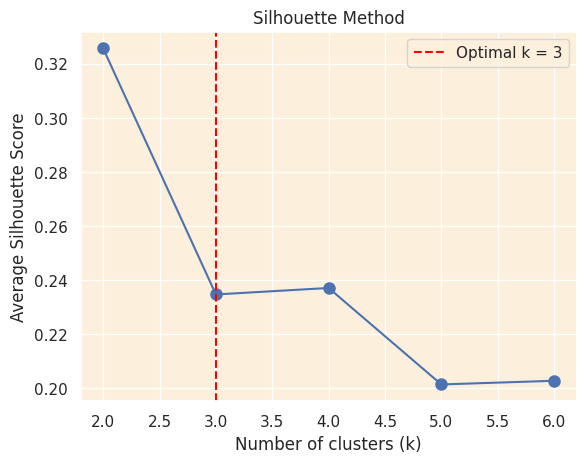

In [116]:
# Silhouette Method

silhouette_avg = []

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_pca)
    cluster_labels = kmeans.labels_

    # Calculate the silhouette score
    silhouette_avg.append(silhouette_score(customer_data_pca, cluster_labels))

# Plot the silhouette scores
plt.plot(range(2, 7), silhouette_avg, 'bo-', markersize=8)
plt.title('Silhouette Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

# Find the optimal k (the one with the highest silhouette score)
optimal_k = range(2, 7)[silhouette_avg.index(max(silhouette_avg))]

# Add a vertical line at the optimal k value
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.show()

### Clustering Model K-Means

In [118]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

customer_data_cleaned.head()

,CustomerID,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay,Is_UK,CancellationFrequency,CancellationRate,MonthlySpending_Mean,MonthlySpending_Std,SpendingTrend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,2
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


## Clustering Evaluation

In [124]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

fig = go.Figure()

fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
                           mode='markers', marker=dict(color='Red', size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
                           mode='markers', marker=dict(color='Green', size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
                           mode='markers', marker=dict(color='Blue', size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)
fig.show()

### Cluster Distribution Visualization

In [125]:
colors = ['#e8000b', '#1ac938', '#023eff']

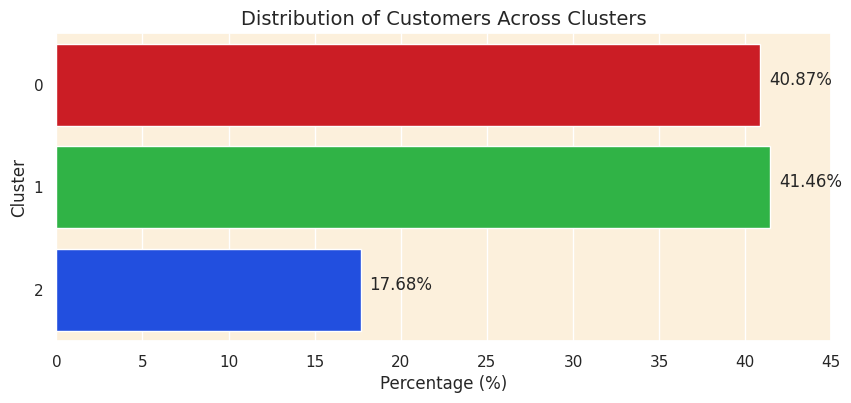

In [126]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')
plt.show()

The distribution of customers across the clusters suggests a failry balanced distribution.

This indicates that clustering process is identifying meaningful patterns within the data.

### Evaluation Metrics

In [132]:
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis = 1)
clusters = customer_data_pca['cluster']

# Compute the metrics
silhouette_avg = silhouette_score(X, clusters)
calinski_harabasz_avg = calinski_harabasz_score(X, clusters)
davies_bouldin_avg = davies_bouldin_score(X, clusters)

# Create a dataframe to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Number of Observations', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'],
    'Value': [num_observations, silhouette_avg, calinski_harabasz_avg, davies_bouldin_avg]
})
metrics_df

,Metric,Value
0,Number of Observations,4070.000000
1,Silhouette Score,0.234888
2,Calinski-Harabasz Score,1263.290059
3,Davies-Bouldin Score,1.377767


* The Silhouette Score of 0.23 indicates a fair amount of separation between the clusters suggesting that clusters are somewhat distinct.
* The Calinski Harabasz Score is 1263.3 indicates that the clusters are well-defined
* The Davies Bouldin Score of 1.37 indicates a moderate level of similarity between each cluster and its most similar one.

In conclusion, the clustering is of good quality.

## Cluster Analysis and Profiling

In [133]:
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()
cluster_centroids

,DaySinceLastPurchase,TotalTransactions,TotalProductsPurchased,TotalSpend,AverageTransactionValue,UniqueProductsPurchased,AvgDaysBetweenPurchases,DayOfWeek,HourOfDay,Is_UK,CancellationFrequency,CancellationRate,MonthlySpending_Mean,MonthlySpending_Std,SpendingTrend
cluster,,,,,,,,,,,,,,,
0,0.150724,-0.313829,-0.336693,-0.351638,-0.117079,-0.224870,-0.034078,0.868150,0.099858,0.016824,-0.279523,-0.229922,-0.200680,-0.268273,-0.014158
1,0.121257,-0.310344,-0.329606,-0.348862,-0.093264,-0.304584,0.084716,-0.848154,-0.071351,-0.017571,-0.234178,-0.185775,-0.178766,-0.276248,0.038527
2,-0.632744,1.453162,1.551183,1.630883,0.489330,1.234024,-0.119881,-0.017910,-0.063514,0.002314,1.195259,0.967103,0.883073,1.267906,-0.057617


In [134]:
# Funcation to create radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

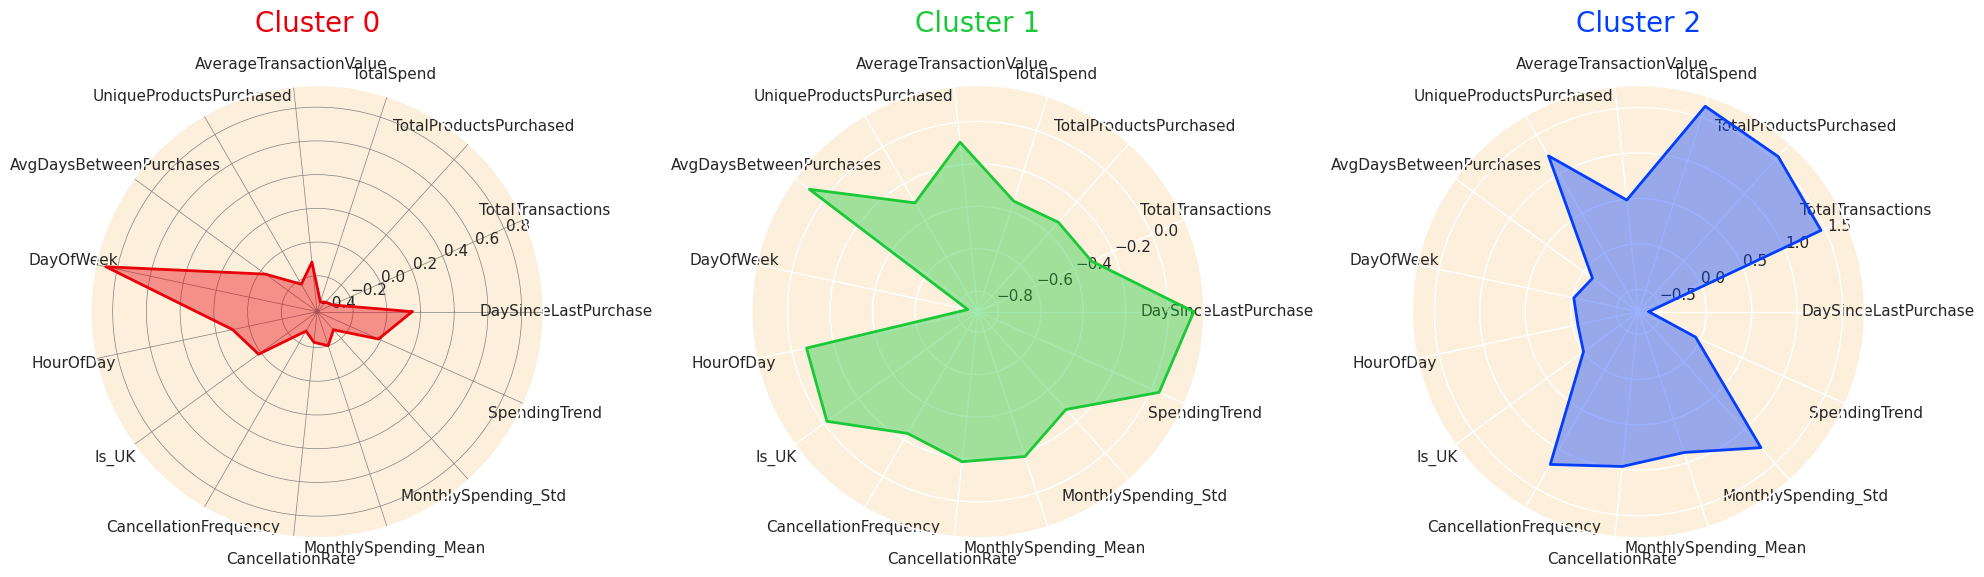

In [135]:
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]
    create_radar_chart(ax[i], angles, data, color, i)

ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])
ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])
ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])
ax[0].grid(color='grey', linewidth=0.5)
plt.tight_layout()
plt.show()

**Cluster 0** : Sporadic Shoppers with a Preference for Weekend Shopping
* Customers tend to spend less, with a lower number of transactions and products purchased.
* They tend to shop during the weekends.
* They have low monthly spending variation.
* These customers have not engaged in many cancellations showing low cancellation frequency and rate.
* The average transaction value is on the lower side, indicating that when they do shop, they tend to spend less per transaction.

**Cluster 1**: Infrequent Big Spenders with a High Spending Trend
* Customers show moderate level of spending with not very frequent transactions as suggested by Days Since last Purchase and Avg Days Between Purchases.
* They have very high spending trend indicating their spending has been increasing over time.
* They prefer shopping late in the day and mainly reside in the UK.
* They have a medium cancellation frequency and rate.
* Their average transaction value is relatively high, meaning that when they shop, they tend to make substantial purchases.

**Cluster 2**: Frequent High-Spenders with a High Rate of Cancellations
* Customer are high spenders with a high total spend and purchase a wide variety of unique products.
* They engage in frequent transactions but also have a high cancellation frequency and rate.
* Customers have a very low average time between purchases and tend to shop early in day.
* Their monthly spending shows high variability indicating their spending patterns might be less predictable compared to other clusters.
* Despite their high spending, they show a low spending trend, suggesting that their high spending levels might be decreasing over time.


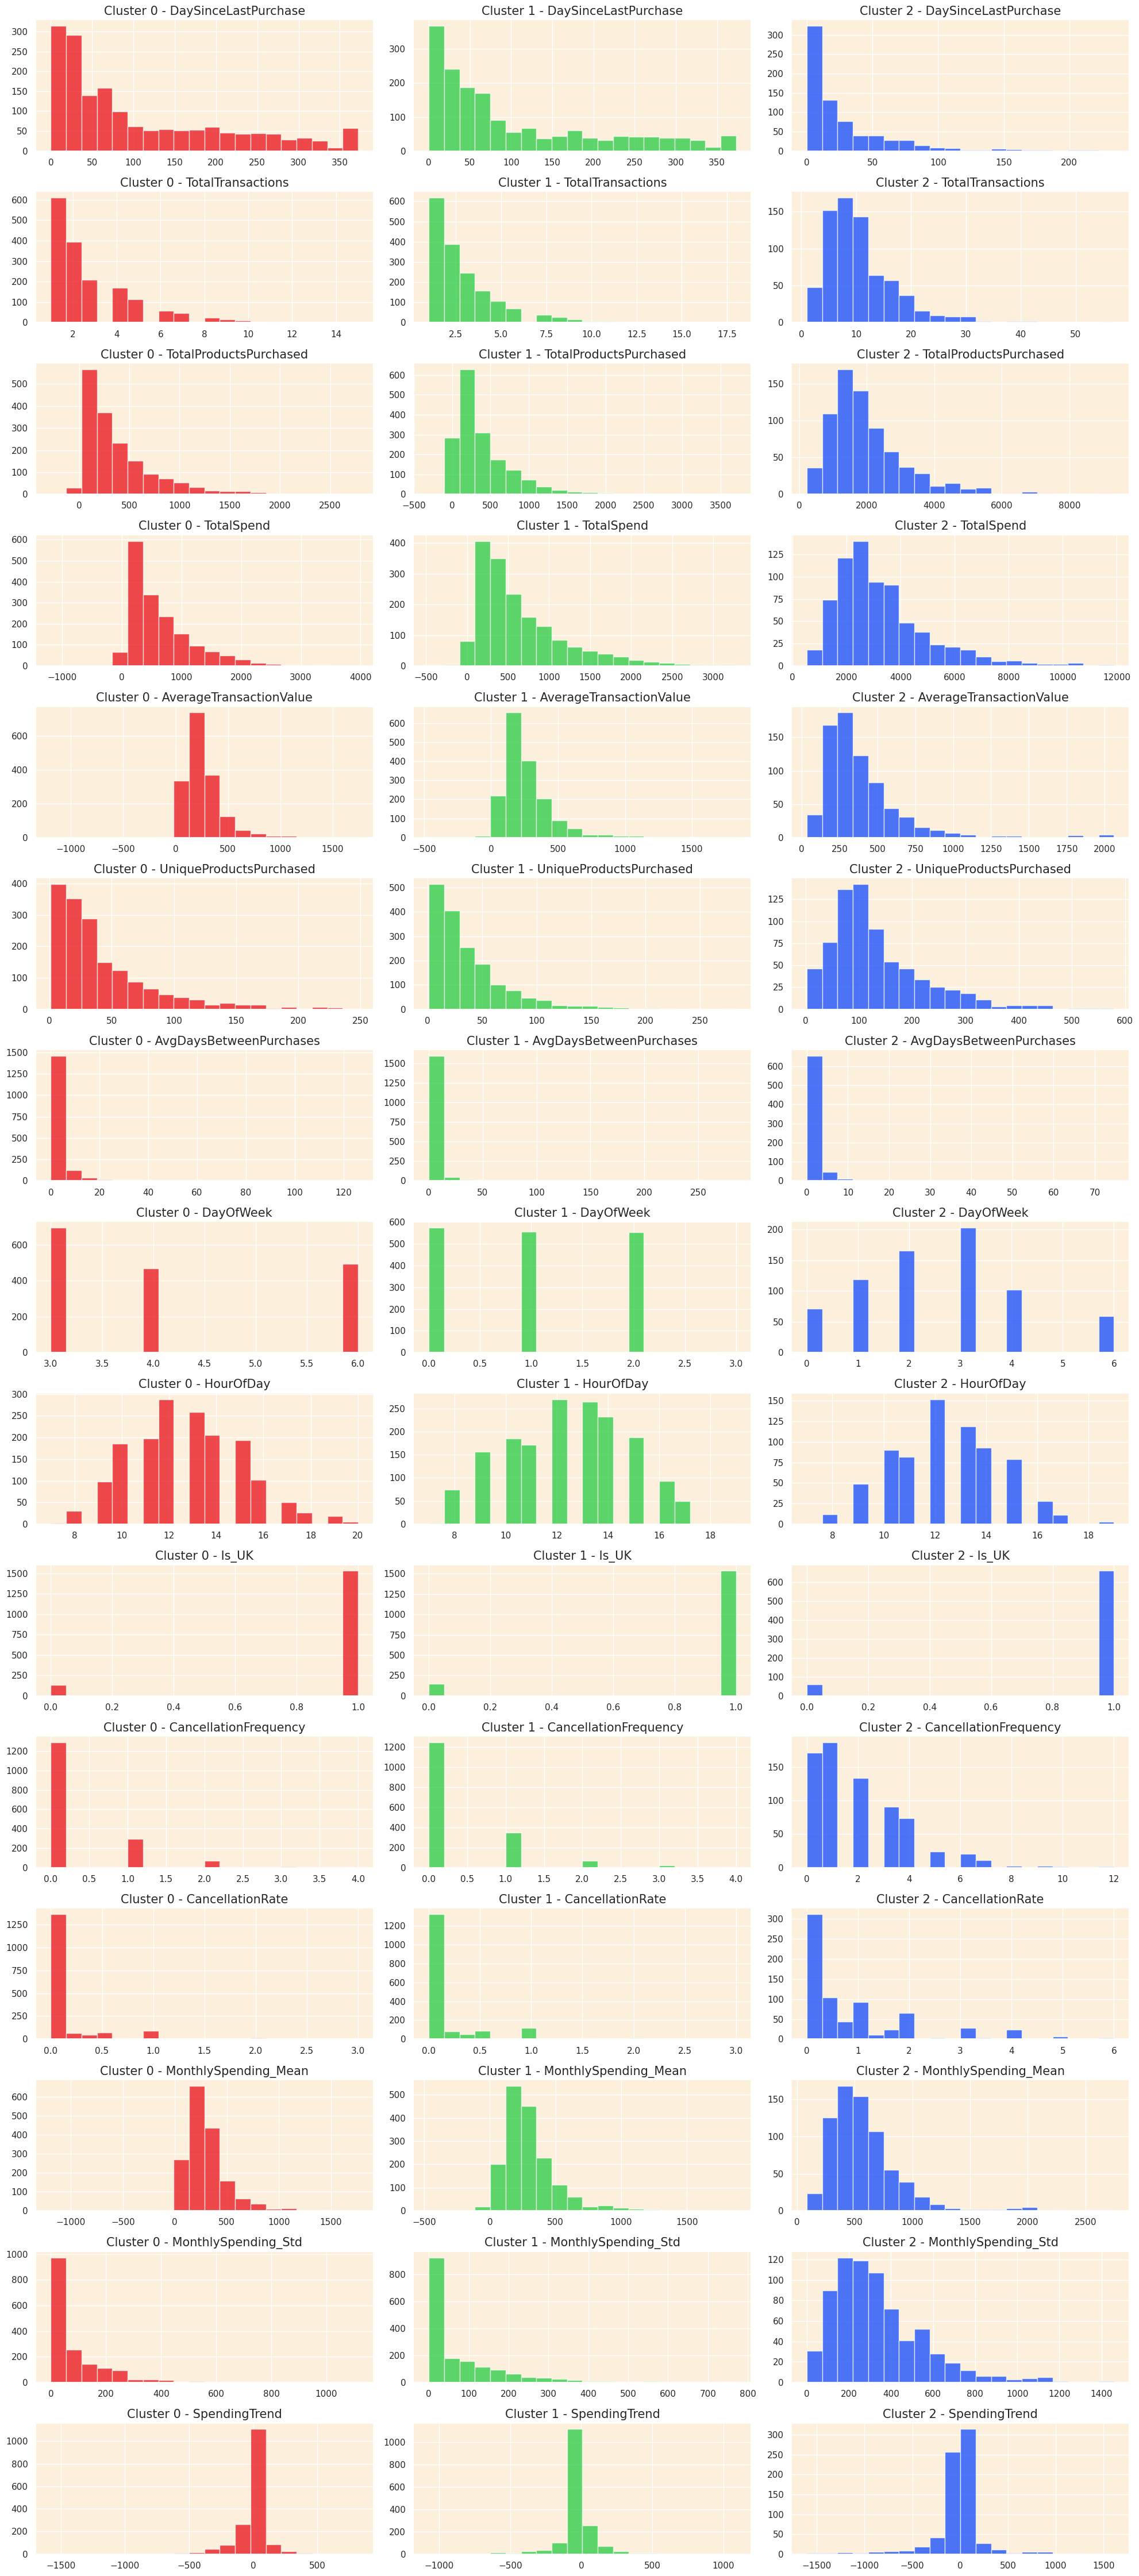

In [136]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()

**Cluster 0: Casual Weekend Shoppers**
* Customers usually shop less frequently and spend less money compared to the other clusters.
* They buy fewer products and have small number of transactions.
* They prefer to shop during the weekends and possibly engage in casual or window shopping.
* They have stable spending habits and show little fluctuation in their monthly spending.
* They rarely cancel their transactions indicating decisive shopping behavior.

**Cluster 1: Occasional Big Spenders**
* Customers don't shop frequently but tend to spend a considerable amount when they do and prefer to buy variety of products.
* Their spending shows growing interest in their purchases.
* They prefer to shop later in the day i.e. after work hours and mainly based in UK.
* They have a moderate tendency to cancel transactions which might be due to thier high spending.
* Their purchases are generally substantial indicating a preference for quality or premium prodcuts.

**Cluster 2: Eager Early-Bird Shoppers**
* Customers have high spending habits and tend to buy a variety of  unique prodcuts and engage in numerous transactions.
* Despite their high expenditure, they cancel significant portin of their transactions, indicating impulsive buying behavior.
* They shop during the early hours of the day, taking advantage of early bird deals.
* Their spending patterns are quite variable with high fluctations in their monthly spending indicating a less predictable shopping pattern.
* Their spending trend is showing sligh decrease, indicating a future change in their shopping habits.

## Recommendation System

In [137]:
# Extract CustomerIDs of the outliers data
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Ensure consistent data type
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Merge the transaction data with customer data
merged_data = pd.merge(df_filtered, customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Create a record of purchases purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Generate recommendations for each customer in each cluster
recommendations = []

for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:

        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
15744.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
15724.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
17414.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
17383.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
15319.0,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
14317.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
15290.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT,22178,VICTORIAN GLASS HANGING T-LIGHT
17594.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
17819.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
